In [3]:
from bitwise_network import *
from binarized_network import *
from binary_layers import *
from datasets.two_source_mixture import *
from datasets.sinusoidal_data import *
from datasets.binary_data import *
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import scipy.signal as signal
from bss_eval import *
import IPython.display as ipd

%load_ext autoreload
%autoreload 2

# Binary Neural Network

In [4]:
# Toy Dataset
toy_binary_set = BinaryDataset('/media/data/binary_audio/toy_val')
with open('/media/data/binary_audio/toy_val/dataset.pkl', 'rb') as f:
    toy_raw_set = pkl.load(f)

In [5]:
# Real Dataset
binary_set = BinaryDataset('/media/data/binary_audio/val')
with open('/media/data/binary_audio/val/dataset.pkl', 'rb') as f:
    raw_set = pkl.load(f)

In [6]:
def evaluate_model(model, binary_sample, raw_sample):
    bmag = torch.tensor(binary_sample['bmag'], dtype=torch.float)
    ibm = torch.tensor(binary_sample['ibm'], dtype=torch.float) 
    bmag = bmag.unsqueeze(0) 
    mix, targ = raw_sample['mixture'], raw_sample['target']
    mix_mag, mix_phase = stft(mix)
    targ_mag, targ_phase = stft(targ)
    inter = mix - targ
    premask = model(2*bmag-1)
    premask = premask.squeeze(0)
    mask = make_binary_mask(premask.detach().numpy(), dtype=np.float)

    # calculate bss eval metrics
    estimate = istft(mask*mix_mag, mix_phase)
    estimate = estimate / np.max(estimate)
    sources = np.stack([targ, inter], axis=1)
    metrics = bss_eval(estimate, sources)

    return metrics, estimate, mask, ibm

def run_evaluation(model, binary_dataset, raw_dataset, num_audio=3):
    bss_metrics = BSSMetricsList()
    for i in range(len(binary_dataset)):
        binary_sample = binary_dataset[i]
        raw_sample = raw_dataset[i]
        metric, estimate, _, _ = evaluate_model(model, binary_sample, raw_sample)
        bss_metrics.append(metric)
        if i % (len(binary_dataset) // num_audio) == 0:
            print('Mixture')
            ipd.display(ipd.Audio(raw_sample['mixture'], rate=16000))
            print('Estimate')
            ipd.display(ipd.Audio(estimate, rate=16000))
            
    sdr, sir, sar = bss_metrics.mean()
    print('Mean SDR %f' % sdr)
    print('Mean SIR %f' % sir)
    print('Mean SAR %f'% sar)
    
def visualize_mask(model, binary_dataset, raw_dataset, index=0):
    binary_sample = binary_dataset[index]
    raw_sample = raw_dataset[index]
    _, _, mask, ibm = evaluate_model(model, binary_sample, raw_sample)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.pcolormesh(ibm, cmap='binary')
    plt.subplot(122)
    plt.pcolormesh(mask, cmap='binary')

## Bitwise Neural Network Evaluation

Mixture


Estimate


Mixture


Estimate


Mixture


Estimate


Mean SDR 0.000377
Mean SIR 0.000377
Mean SAR 95.950694


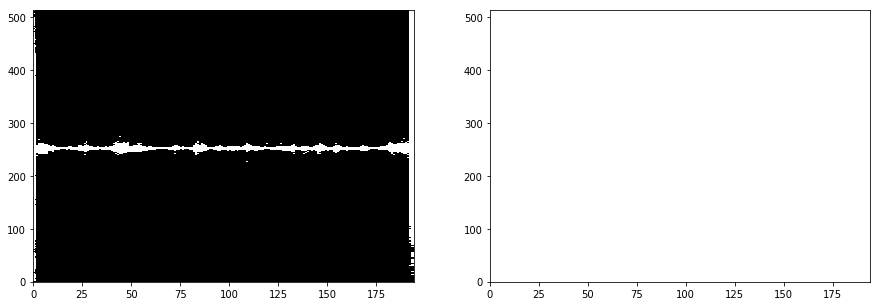

In [7]:
# Toy real network
toy_nn = BitwiseNetwork(2052, 513, fc_sizes=[1024, 1024])
toy_nn.eval()
toy_nn.load_state_dict(torch.load('models/toy_real_network.model'))
run_evaluation(toy_nn, toy_binary_set, toy_raw_set)
visualize_mask(toy_nn, toy_binary_set, toy_raw_set)

Mixture


Estimate


Mixture


Estimate


Mixture


Estimate


Mixture


Estimate


Mean SDR 45.975982
Mean SIR 90.953481
Mean SAR 47.116166


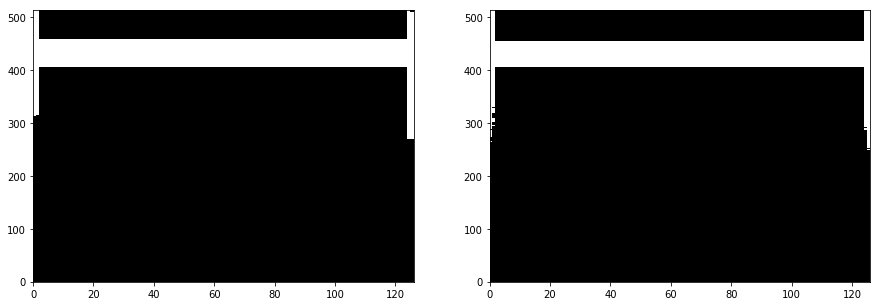

In [7]:
# Toy bitwise network
toy_bnn = BitwiseNetwork(2052, 513, fc_sizes=[1024])
toy_bnn.load_state_dict(torch.load('models/toy_bitwise_network.model'))
toy_bnn.inference()
toy_bnn.eval()
run_evaluation(toy_bnn, toy_binary_set, toy_raw_set, 3)
visualize_mask(toy_bnn, toy_binary_set, toy_raw_set, index=0)

Mixture


Estimate


Mixture


Estimate


Mixture


Estimate


Mean SDR 6.270034
Mean SIR 19.057875
Mean SAR 6.809827


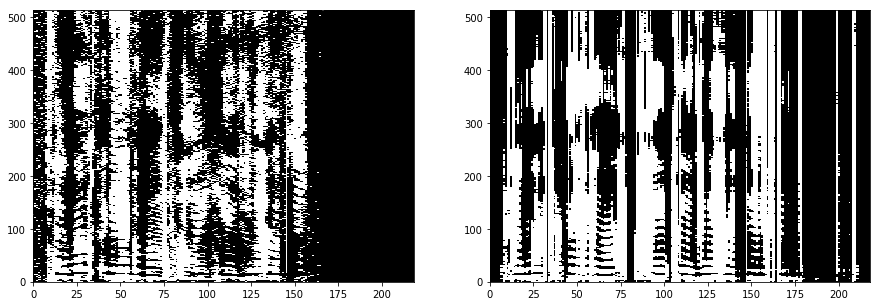

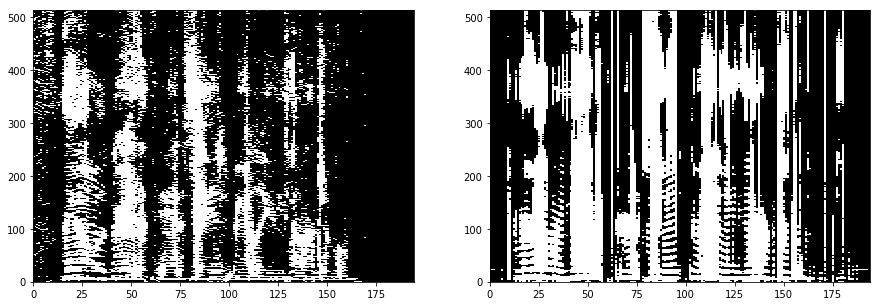

In [8]:
# Evaluate real network
nn = BitwiseNetwork(2052, 513, fc_sizes=[4096, 4096])
nn.eval()
nn.load_state_dict(torch.load('models/real_network.model'))
run_evaluation(nn, binary_set, raw_set)
visualize_mask(nn, binary_set, raw_set, 100)
visualize_mask(nn, binary_set, raw_set, 2)

Mixture


Estimate


Mixture


Estimate


Mixture


Estimate


Mean SDR -8.950435
Mean SIR 8.469672
Mean SAR -7.555825


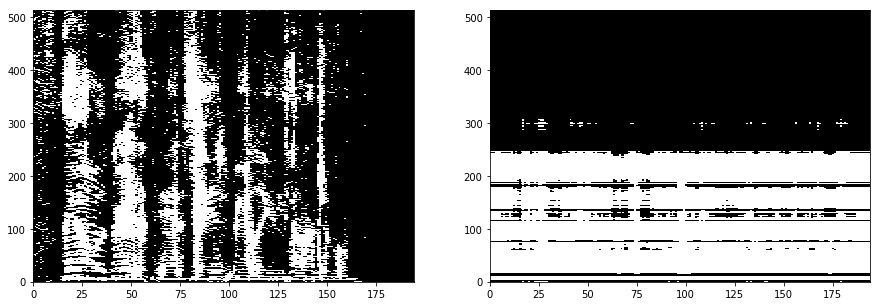

In [7]:
# Evaluate bitwise network
nn = BitwiseNetwork(2052, 513, fc_sizes=[4096, 4096])
nn.eval()
nn.load_state_dict(torch.load('models/bitwise_network.model'))
run_evaluation(nn, binary_set, raw_set)
visualize_mask(nn, binary_set, raw_set, 2)

## Binarized Networks

Mixture


Estimate


Mixture


Estimate


Mixture


Estimate


Mean SDR 6.188095
Mean SIR 14.849493
Mean SAR 7.277234


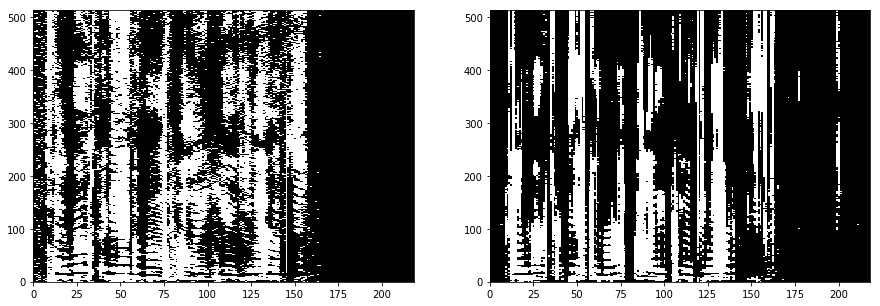

In [9]:
bin_net = BinarizedNetwork(2052, 513, fc_sizes=[2048, 2048, 2048])
bin_net.eval()
bin_net.load_state_dict(torch.load('models/bin_network.model'))
run_evaluation(bin_net, binary_set, raw_set)
visualize_mask(bin_net, binary_set, raw_set, 100)